<a href="https://colab.research.google.com/github/ArtyomShabunin/SMOPA/blob/main/lesson_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://prana-system.com/files/110/rds_color_full.png" alt="tot image" width="300"  align="center"/> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<img src="https://mpei.ru/AboutUniverse/OficialInfo/Attributes/PublishingImages/logo1.jpg" alt="mpei image" width="200" align="center"/>
<img src="https://mpei.ru/Structure/Universe/tanpe/structure/tfhe/PublishingImages/tot.png" alt="tot image" width="100"  align="center"/>

---

# **Системы машинного обучения и предиктивной аналитики в тепловой и возобновляемой энергетике**  

# ***Практические занятия***


---



# Занятие №3
# Поиск аномалий методами машинного обучения

**5 марта 2025г.**

---

С точки зрения машинного оучения задачу поиска поиска аномалий можно разделить на два возможных типа:
* **Outlier detection** (поиск выбросов): в тренировочной выборке содержатся выбросы, которые определяются как наблюдения, лежащие далеко от остальных. Таким образом, алгоритмы для детектирования выбросов пытаются найти регионы, где сосредоточена основная масса тренировочных данных, игрорируя аномальные наблюдения.
* **Novelty detection** (поиск "новизны"): тренировочная выборка не загрязнена выбросами, и мы хотим научиться отвечать на вопрос "является ли новое наблюдение выбросом".

In [ ]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import seaborn as sns
sns.set_theme(style="whitegrid", rc={'figure.figsize':(15,6)})
# matplotlib.rc('xtick', labelsize=20)
# matplotlib.rc('ytick', labelsize=20)

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import glob

import ipywidgets as widgets
from IPython.display import display, clear_output
import plotly.graph_objs as go

pd.options.mode.chained_assignment = None

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Загрузка данных

In [ ]:
data = pd.read_parquet("/content/drive/MyDrive/SMOPA/data.gzip")

signals = [
    'GTA1.DBinPU.Aldi', 'GTA1.DBinPU.Alvna', 'GTA1.DBinPU.Alzzo',
    'GTA1.DBinPU.Bo', 'GTA1.DBinPU.fi', 'GTA1.DBinPU.nst',
    'GTA1.DBinPU.ntk', 'GTA1.DBinPU.P', 'GTA1.DBinPU.Pk', 'GTA1.DBinPU.Pvh',
    'GTA1.DBinPU.Qtg', 'GTA1.DBinPU.Tk', 'GTA1.DBinPU.Tn', 'GTA1.DBinPU.Tt']

data = data.loc[:, signals]

In [ ]:
data.shape

(12934, 14)

Сформируем тренировочную и тестовую выборки.

In [ ]:
shuffled_data = data.sample(frac=1)

data_train = shuffled_data.iloc[:round(shuffled_data.shape[0]*0.8), :]
data_test = shuffled_data.iloc[round(shuffled_data.shape[0]*0.8):, :]

NUMBER_OF_ANOMALY_POINTS = round(data_test.shape[0]*0.5)
data_test["anomaly"] = 0
data_test.loc[data_test.iloc[:NUMBER_OF_ANOMALY_POINTS].index, ["anomaly"]] = 1

Добавим шум на половину тестовых данных и отметим их как аномальные

In [ ]:
NUMBER_OF_ANOMALY_POINTS = round(data_test.shape[0]*0.5)
data_test["anomaly"] = 0
data_test.loc[
    data_test.iloc[:NUMBER_OF_ANOMALY_POINTS].index, ["anomaly"]] = 1
mask = np.random.choice(
    [0, 1],
    size=[NUMBER_OF_ANOMALY_POINTS, data.shape[1]],
    p=[.3, .7])
assert mask.sum(axis=1).min() != 0

bias = mask * np.random.choice(
    [0.01, 0.02, 0.03, 0.04, 0.05, -0.01, -0.02, -0.03, -0.04, -0.05],
    size=[NUMBER_OF_ANOMALY_POINTS, data.shape[1]],
    p=[.1, .1, .1, .1, .1, .1, .1, .1, .1, .1])
data_test.loc[
    data_test.iloc[:NUMBER_OF_ANOMALY_POINTS].index,
    data.columns] = data_test[data_test["anomaly"] == 1][data.columns] * (1 + bias)

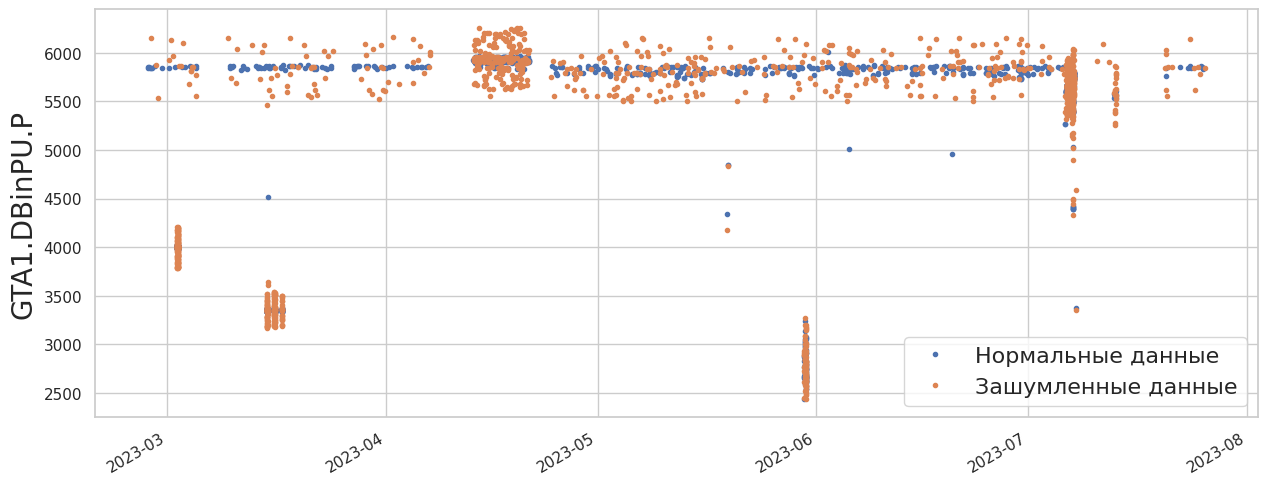

In [ ]:
fig = plt.figure();

data_test[data_test["anomaly"] == 0]["GTA1.DBinPU.P"].plot(style='.', label="Нормальные данные");
data_test[data_test["anomaly"] == 1]["GTA1.DBinPU.P"].plot(style='.', label="Зашумленные данные");
plt.ylabel("GTA1.DBinPU.P", fontsize=20);
plt.legend(prop={'size': 16});

# fig.savefig('fig9.png', dpi=fig.dpi, bbox_inches='tight');

In [ ]:
# train_data = pd.read_parquet("../lesson-3/train.gzip")
# test_data = pd.read_parquet("../lesson-3/test.gzip")

### Нормализация данных

In [ ]:
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(
    scaler.fit_transform(data_train),
    columns=data_train.columns,
    index=data_train.index)

X_test = pd.DataFrame(
    scaler.transform(data_test[data.columns]),
    columns=data.columns,
    index=data_test.index)

X_train.describe()

,GTA1.DBinPU.Aldi,GTA1.DBinPU.Alvna,GTA1.DBinPU.Alzzo,GTA1.DBinPU.Bo,GTA1.DBinPU.fi,GTA1.DBinPU.nst,GTA1.DBinPU.ntk,GTA1.DBinPU.P,GTA1.DBinPU.Pk,GTA1.DBinPU.Pvh,GTA1.DBinPU.Qtg,GTA1.DBinPU.Tk,GTA1.DBinPU.Tn,GTA1.DBinPU.Tt
count,10347.000000,10347.000000,10347.000000,10347.000000,10347.000000,10347.000000,10347.000000,10347.000000,10347.000000,10347.000000,10347.000000,10347.000000,10347.000000,10347.000000
mean,0.648940,0.745363,0.046157,0.521635,0.481316,0.355093,0.589162,0.749162,0.733318,0.488586,0.543314,0.491221,0.567096,0.538942
std,0.279381,0.257898,0.191824,0.166493,0.179894,0.190388,0.313993,0.304318,0.276848,0.192651,0.257235,0.300073,0.259151,0.285569
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.367488,0.546121,0.000942,0.434168,0.322796,0.203328,0.246283,0.445037,0.463525,0.370513,0.369900,0.223991,0.341020,0.332556
50%,0.778395,0.862911,0.001820,0.503226,0.482087,0.378558,0.669459,0.911174,0.862731,0.418953,0.614347,0.481692,0.534929,0.555709
75%,0.862305,0.919328,0.002811,0.644519,0.615307,0.477324,0.872342,0.963986,0.932539,0.509080,0.762872,0.800670,0.812239,0.816457
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# X_train = X_train.iloc[:round(0.1*X_train.shape[0]),:]
# X_test = X_test.iloc[:round(0.1*X_train.shape[0]),:]

In [ ]:
print(X_train.shape)
print(X_test.shape)

(10347, 14)
(2587, 14)


## Метод опорных векторов (Support Vector Machines — SVM)

Один из наиболее популярных методов обучения, который применяется для решения задач классификации и регрессии. Основная идея метода заключается в построении гиперплоскости, разделяющей объекты выборки оптимальным способом. Алгоритм работает в предположении, что чем больше расстояние (зазор) между разделяющей гиперплоскостью и объектами разделяемых классов, тем меньше будет средняя ошибка классификатора.

![svm image](https://frankworkshophome.wordpress.com/wp-content/uploads/2019/12/7-1.png)

Класс OneClassSVM реализует одноклассную SVM, которая используется для обнаружения выбросов. Если мы имеем дело с задачей novelty detection, где для тренировки нам доступны только "хорошие" наблюдения без аномалий, то мы можем воспользоваться этой моделью и научиться для каждого нового наблюдения говорить, является ли оно аномальным или нет.

Общая идея OneClassSVM преобразовать признаковое пространство и провести разделяющую гиперплоскость так, чтобы наблюдения лежали как можно дальше от начала координат.
В результате мы получаем границу, по одну сторону которой максимально плотно упакованы наблюдения из нашей чистой тренировочной выборки, а по другую будут находится аномальные значения, не похожие на то, что алгоритм видел во время обучения.

**Плюсы и минусы**  
\+ Благодаря kernel trick, модель способна проводить нелинейные разделяющие границы  
\+ Особенно удобно использовать, когда в данных недостаточно "плохих" наблюдений, чтобы использовать стандартный подход обучения с учителем — бинарную классификацию  
\- Может очень сильно переобучиться и выдавать большое количество ложно отрицательных результатов, если разделяющий зазор слишком мал  
\- И, конечно, нужно быть абсолютно уверенным, что тренировочные данные не содержат никаких выбросов, иначе алгоритм будет считать их нормальными наблюдениями

In [ ]:
kernel = widgets.Dropdown(
    options=['linear', 'poly', 'rbf', 'sigmoid'],
    value='rbf',
    description='Kernel:',
    disabled=False,
)

nu = widgets.FloatSlider(
    value=0.1,
    min=0,
    max=1,
    step=0.01,
    description='nu:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

widgets.VBox([
    widgets.Label('Тип ядра, который будет использоваться в алгоритме'),
    kernel,
    widgets.Label('Верхняя граница доли ошибок обучения и нижняя граница доли опорных векторов'),
    nu])

In [ ]:
ocsvm = OneClassSVM(kernel=kernel.value, nu=nu.value)
ocsvm.fit(X_train)

print(f"Число опорных векторов - {ocsvm.n_support_}")

Число опорных векторов - [1042]


Оценим тестовые данные

In [ ]:
data_test.loc[:,'anomaly_svm'] = (ocsvm.predict(X_test) == -1).astype(int)

### Визуализация аномальных данных

In [ ]:
signals

['GTA1.DBinPU.Aldi',
 'GTA1.DBinPU.Alvna',
 'GTA1.DBinPU.Alzzo',
 'GTA1.DBinPU.Bo',
 'GTA1.DBinPU.fi',
 'GTA1.DBinPU.nst',
 'GTA1.DBinPU.ntk',
 'GTA1.DBinPU.P',
 'GTA1.DBinPU.Pk',
 'GTA1.DBinPU.Pvh',
 'GTA1.DBinPU.Qtg',
 'GTA1.DBinPU.Tk',
 'GTA1.DBinPU.Tn',
 'GTA1.DBinPU.Tt']

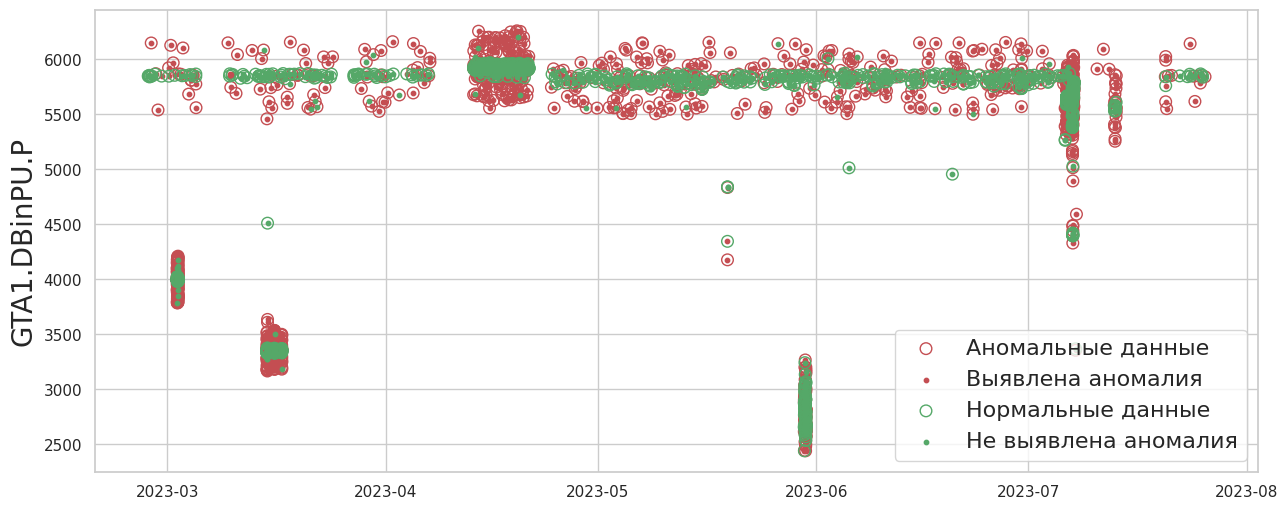

In [ ]:
fig = plt.figure();

signal = 'GTA1.DBinPU.P'

plt.scatter(
    data_test[data_test['anomaly'] == 1][signal].index,
    data_test[data_test['anomaly'] == 1][signal].values,
    s=70, facecolors='none', edgecolors='r', label= "Аномальные данные");

plt.scatter(
    data_test[data_test['anomaly_svm'] == 1][signal].index,
    data_test[data_test['anomaly_svm'] == 1][signal].values,
    s=10, facecolors='r', edgecolors='r', label= "Выявлена аномалия");

plt.scatter(
    data_test[data_test['anomaly'] == 0][signal].index,
    data_test[data_test['anomaly'] == 0][signal].values,
    s=70, facecolors='none', edgecolors='g', label= "Нормальные данные");

plt.scatter(
    data_test[data_test['anomaly_svm'] == 0][signal].index,
    data_test[data_test['anomaly_svm'] == 0][signal].values,
    s=10, facecolors='g', edgecolors='g', label= "Не выявлена аномалия");

plt.ylabel(signal, fontsize=20);
plt.legend(prop={'size': 16});

# fig.savefig('fig10.png', dpi=fig.dpi, bbox_inches='tight');

In [ ]:
# try:
#     scat_1 = X_test.groupby('anomaly_svm').get_group(1)
#     scat_0 = X_test.groupby('anomaly_svm').get_group(-1)
# except KeyError:
#     print("Не удалось разделить данные")

# params_dropdown = widgets.Dropdown(
#     options=X_test.columns,
#     description='Параметр:',
#     disabled=False,
#     value=None
# )

# out = widgets.Output()
# display(out)

# with out:
#     display(params_dropdown)

# @out.capture()
# def params_dropdown_eventhandler(change):

#     clear_output()
#     display(params_dropdown)
#     # selected_param = selected_params_kks[list(selected_params_description).index(change.new)]


#     fig, axes = plt.subplots(1, 1, figsize=(15,5))
#     plt.title(f"{change.new}")
#     plt.plot(scat_1[change.new], 'g.', markersize=5)
#     plt.plot(scat_0[change.new], 'r.', markersize=5)
#     display(fig)

# params_dropdown.observe(params_dropdown_eventhandler, names='value')

### Оценка новизны (аномальности данных) данных

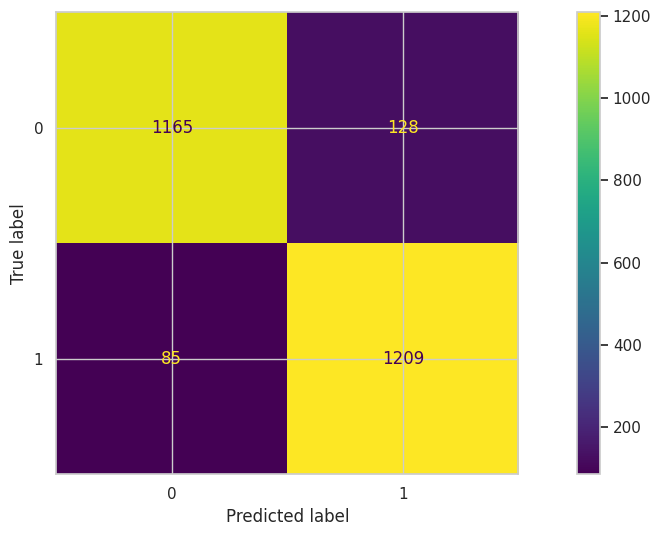

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_mat = confusion_matrix(data_test['anomaly'], data_test['anomaly_svm'])
ConfusionMatrixDisplay(conf_mat).plot()
plt.show()

In [ ]:
tn, fp, fn, tp = conf_mat.ravel()
print("True Negative:", tn)
print("False Negative:", fn)
print("True Positive:", tp)
print("False Positive:", fp)

True Negative: 1165
False Negative: 85
True Positive: 1209
False Positive: 128


***accuracy*** - пропорция верно предсказанных наблюдений  
***precision*** - с какой вероятностью положительные предсказания правильные  
***recall*** - отражает способность модели определять наблюдения положительного класса  
***F1*** - какое количество названных положительными наблюдений являются истинноположительными:

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print(f"accuracy - {accuracy_score(data_test['anomaly'], data_test['anomaly_svm'])*100:0.2f}%")
print(f"precision - {precision_score(data_test['anomaly'], data_test['anomaly_svm'], average='binary')*100:0.2f}%")
print(f"recall - {recall_score(data_test['anomaly'], data_test['anomaly_svm'], average='binary')*100:0.2f}%")
print(f"F1 - {f1_score(data_test['anomaly'], data_test['anomaly_svm'], average='binary')*100:0.2f}%")


accuracy - 91.77%
precision - 90.43%
recall - 93.43%
F1 - 91.90%


In [ ]:
data_test.loc[:,'svm_score'] = ocsvm.score_samples(X_test)

In [ ]:
# fig = plt.figure();

# signal = 'GTA1.DBinPU.P'

# plt.scatter(
#     data_test[data_test['anomaly'] == 1][signal].index,
#     data_test[data_test['anomaly'] == 1][signal].values,
#     s=70, facecolors='none', edgecolors='r', label= "Нормальные данные");

# plt.scatter(
#     data_test[data_test['anomaly_svm'] == 1][signal].index,
#     data_test[data_test['anomaly_svm'] == 1][signal].values,
#     s=10, facecolors='r', edgecolors='r', label= "Выявлена аномалия");

# plt.scatter(
#     data_test[data_test['anomaly'] == 0][signal].index,
#     data_test[data_test['anomaly'] == 0][signal].values,
#     s=70, facecolors='none', edgecolors='g', label= "Нормальные данные");

# plt.scatter(
#     data_test[data_test['anomaly_svm'] == 0][signal].index,
#     data_test[data_test['anomaly_svm'] == 0][signal].values,
#     s=10, facecolors='g', edgecolors='g', label= "Не выявлена аномалия");

# plt.ylabel(signal, fontsize=20);
# plt.legend(prop={'size': 16});

# # fig.savefig('fig10.png', dpi=fig.dpi, bbox_inches='tight');

In [ ]:
data_test.columns

Index(['GTA1.DBinPU.Aldi', 'GTA1.DBinPU.Alvna', 'GTA1.DBinPU.Alzzo',
       'GTA1.DBinPU.Bo', 'GTA1.DBinPU.fi', 'GTA1.DBinPU.nst',
       'GTA1.DBinPU.ntk', 'GTA1.DBinPU.P', 'GTA1.DBinPU.Pk', 'GTA1.DBinPU.Pvh',
       'GTA1.DBinPU.Qtg', 'GTA1.DBinPU.Tk', 'GTA1.DBinPU.Tn', 'GTA1.DBinPU.Tt',
       'anomaly', 'anomaly_svm', 'svm_score'],
      dtype='object')

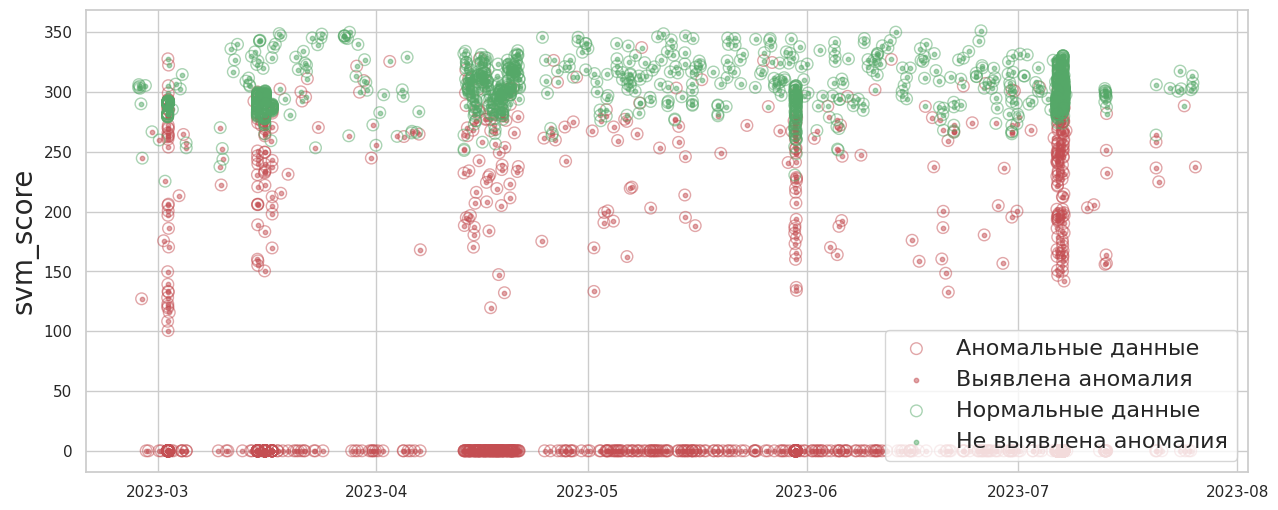

In [ ]:
fig = plt.figure();

signal = 'svm_score'

plt.scatter(
    data_test[data_test['anomaly'] == 1][signal].index,
    data_test[data_test['anomaly'] == 1][signal].values,
    s=70, facecolors='none', edgecolors='r',
    label= "Аномальные данные", alpha=0.5);

plt.scatter(
    data_test[data_test['anomaly_svm'] == 1][signal].index,
    data_test[data_test['anomaly_svm'] == 1][signal].values,
    s=10, facecolors='r', edgecolors='r',
    label= "Выявлена аномалия", alpha=0.5);

plt.scatter(
    data_test[data_test['anomaly'] == 0][signal].index,
    data_test[data_test['anomaly'] == 0][signal].values,
    s=70, facecolors='none', edgecolors='g',
    label= "Нормальные данные", alpha=0.5);

plt.scatter(
    data_test[data_test['anomaly_svm'] == 0][signal].index,
    data_test[data_test['anomaly_svm'] == 0][signal].values,
    s=10, facecolors='g', edgecolors='g',
    label= "Не выявлена аномалия", alpha=0.5);

# plt.plot(data_test.index,
#          np.ones(data_test.shape[0])*100, color='red', linewidth=5);

plt.ylabel(signal, fontsize=20);
plt.legend(prop={'size': 16}, loc='lower right');

# fig.savefig('fig10.png', dpi=fig.dpi, bbox_inches='tight');

In [ ]:
from sklearn.manifold import TSNE

coords = TSNE(n_components=2,random_state=42).fit_transform(X_train)
coords_1 = TSNE(n_components=1,random_state=42).fit_transform(X_train)

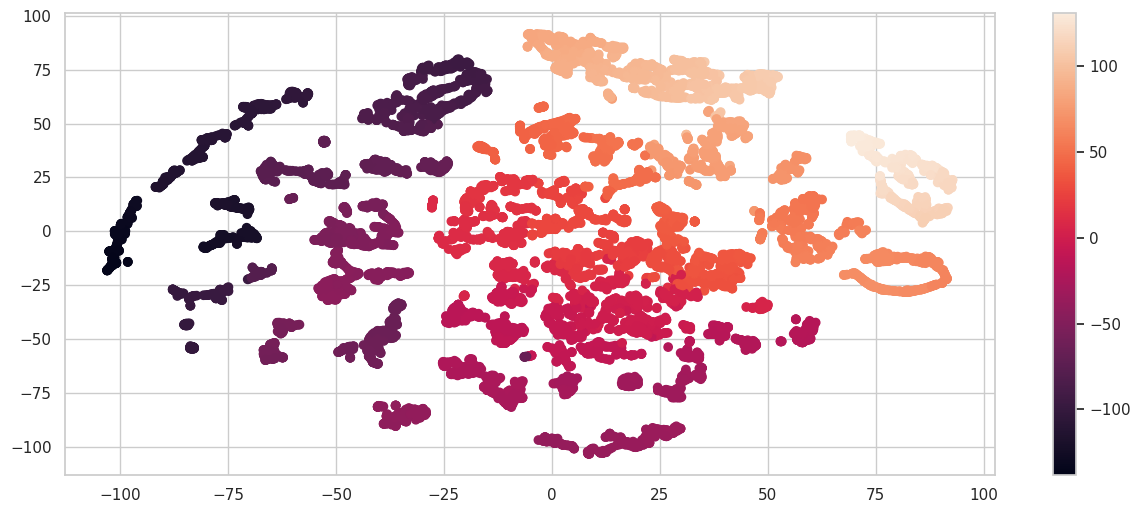

In [ ]:
plt.scatter(coords[:, 0], coords[:, 1], c=coords_1[:,0]);
plt.colorbar();

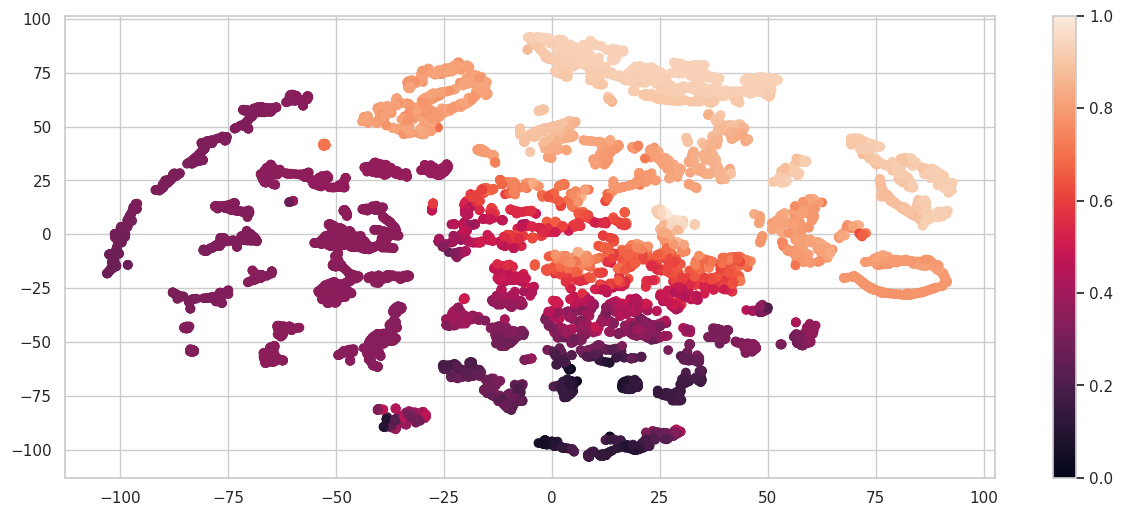

In [ ]:
plt.scatter(coords[:, 0], coords[:, 1], c=X_train['GTA1.DBinPU.Tn'].values);
plt.colorbar();

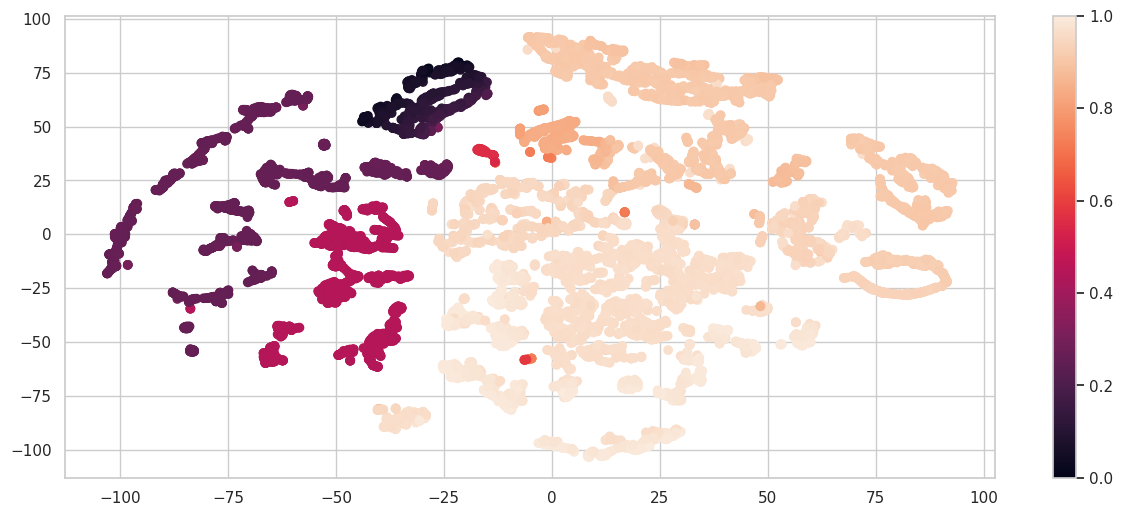

In [ ]:
plt.scatter(coords[:, 0], coords[:, 1], c=X_train['GTA1.DBinPU.P'].values);
plt.colorbar();

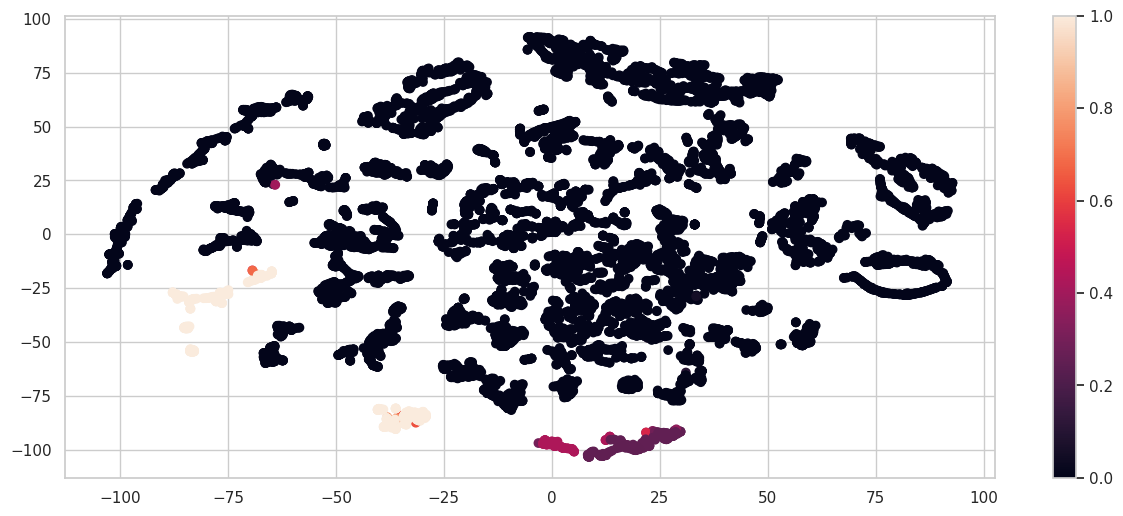

In [ ]:
plt.scatter(coords[:, 0], coords[:, 1], c=X_train['GTA1.DBinPU.Alzzo'].values);
plt.colorbar();